# Quickly Detecting Anomalies in Web site traffic

---

***Final Project, FAES BIOF 309 Introduction to Python, Fall 2018***

**Marie Gallagher, mgallagher@mail.nih.gov**

## Overview

The purpose of this project is to provide a faster way to visualize
data than (repeatedly) importing data into Excel and creating a 
chart.  This will save me time!

## Background

One of my work tasks is to provide statistics about Web site use.
Over the years, my institute has mandated various Web analytics software
including: awstats, WebTrends and Google Analytics.

Each piece of software analyzes and displays results differently.
So switching to different Web analytics software usually creates the 
appearance of a massive increase or decrease in traffic.

I need a way to tell whether there has been a legitimate unexpected
change in Web site traffic.  Unique IP addresses per day turns out 
to be a reasonably reliable indicator.

Anomalies can also happen if the Web site is the subject of a denail
of service attack or if an event of national or international interest 
is related to content on the Web site.  Having a way to quickly visualize 
the number of unique IP addresses daily over time will help me quickly 
spot anomalies.

## Demo

My data for this project contains the number of unique IP addresses 
accessing a Web site each day.  A few lines of data follows:
```
06/01/2018|5565|515120|515120|515120
06/02/2018|4801|518657|518657|518657
06/03/2018|4069|451881|451881|451881
06/04/2018|4859|493762|493762|493762
06/05/2018|4816|514587|514587|514587
```

- We are interested in the first two columns.  We want to ignore the rest of the columns.

- The first column contains dates, but they are in the form MM/DD/YYYY rather than YYYY-MM-DD.

- There are no column headers in this data.

- The columns are separated by the "pipe" character rather than commas, spaces or tabs.

In [1]:
# Import the necessary packages
import os

In [2]:
# Decide later whether urllib.request package or requests package is preferred.
# For now, go with requests package and print the version to satisfy my curiosity.
import requests
requests.__version__

'2.18.4'

In [3]:
# List the version of the numpy package, just to satifsy my curiosity
import numpy as np
np.__version__

'1.14.3'

In [4]:
# Thanks to Martin for requirements.txt that imports pandas into Binder!
import pandas as pd
pd.__version__

'0.23.0'

In [5]:
# In case of error in Binder, check requirements.txt for missing matplotlib line.
import matplotlib.pyplot as plt
# May not need either of the following.  Experiment and test...
%matplotlib inline
# %matplotlib notebook

In [6]:
from datetime import datetime

In [7]:
# Specify the location of the data files.
# When developing or running locally, having data files in the local directory works great.
# You need variable data_dir if you are developing or running locally.
data_dir = "./data/raw/"
# But...  putting files in a local directory, such as "./data/raw/", does not work with Google Colaboratory and Binder.
# When running this notebook in Binder or Colaboratory, you need to provide a URL to the location of the data files.
# You need variable url_path if running from Google Colaboratory or Binder.
url_path = 'https://raw.githubusercontent.com/BIOF309/group-project-marie_gallagher_final_project/master/notebooks/data/raw/'

In [8]:
# Workaround for not being able to read files when using Colaboratory or Binder.  
# use_data_from = "data_dir" when working locally.
# use_data_from = "url_path" when NOT working locally.
use_data_from = "url_path"
# Check for a typo in the value of use_data_from.
if (use_data_from != "url_path" and use_data_from != "data_dir"):
    raise ValueError("use_data_from should be either 'url_path' or 'data_dir'")

In [9]:
# Optional: display the names of the files in the raw data directory.
if use_data_from == "data_dir":
    print(os.listdir(data_dir))

In [10]:
# Choose a data file to plot.
file_name = "log_daily_ip_201806a.txt"
if use_data_from == "data_dir":
    daily_ip_file = data_dir + file_name
elif use_data_from == "url_path":
    daily_ip_file = url_path + file_name

In [11]:
# Optional:  display the first few lines of the daily_ip_file.
lines_to_display = 3
if use_data_from == "data_dir":
    with open(daily_ip_file) as file:
        line_num = 1
        while line_num <= lines_to_display:
            print(file.readline())
            line_num = line_num + 1
    file.close()
elif use_data_from == "url_path":
    # Thanks to https://stackoverflow.com/questions/1393324/in-python-given-a-url-to-a-text-file-what-is-the-simplest-way-to-read-the-cont
    response = requests.get(daily_ip_file)
    raw_data_lines = response.text.split('\n')
    line_num = 1
    while line_num <= lines_to_display:
        print(raw_data_lines[line_num-1])
        line_num = line_num + 1

06/01/2018|5565|515120|515120|515120
06/02/2018|4801|518657|518657|518657
06/03/2018|4069|451881|451881|451881


In [12]:
# Read the data file into a pandas dataframe, df.
# The columns separator is '|'.
# There is no header row.
# We only need the first two columns.
df = pd.read_csv(daily_ip_file, sep="|", header=None, usecols=[0,1])

In [13]:
# Optional: display the first few rows of df.  There should now be only two columns, not five.
print(df.head(3))

            0     1
0  06/01/2018  5565
1  06/02/2018  4801
2  06/03/2018  4069


In [14]:
# Give the dataframe's columns descriptive names.
df.columns = ["dates", "unique_ips"]

In [15]:
# Optional: make sure the column names have changed.  Display information about the columns.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
dates         30 non-null object
unique_ips    30 non-null int64
dtypes: int64(1), object(1)
memory usage: 560.0+ bytes
None


In [16]:
# Optional: what is the type of the df.dates column, first row?
print(type(df.dates[0]))

<class 'str'>


In [17]:
# Convert the "object" data in the df.dates column to date/time objects so they will be treated as such.

# Thanks to Burke Squires for this function adapted from
# https://github.com/burkesquires/python_biologist/blob/master/05_python_data_analysis

# Define a function to convert a string (m/d/yyyy) to a date
def string_to_date(date_text):
    '''
    string_to_date(a_str) converts a_str from format mm/dd/yyyy to a datetime object yyyy-mm-dd.
    string_to_date("12/25/2018") converts string 12/25/2018 to datetime object 2018-12-25.
    '''
    return datetime.strptime(date_text, "%m/%d/%Y")

# Run the string_to_date function on every date string and overwrite the df.dates column
df.dates = df.dates.apply(string_to_date)

In [18]:
# Optional: what is the type of the df.dates column, first row, now?  Before it was str.
print(type(df.dates[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [19]:
# Optional: Display information about the columns.  Now df.dates is datetime64 instead of object.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
dates         30 non-null datetime64[ns]
unique_ips    30 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 560.0 bytes
None


In [20]:
# Optional: what does the data in the df.dates column look like now?  yyyy-mm-dd instead of mm/dd/yyyy!
print(df.dates.head(3))

0   2018-06-01
1   2018-06-02
2   2018-06-03
Name: dates, dtype: datetime64[ns]


In [21]:
# Caution:
# Don't do this:  df = df.set_index('dates')
# Don't set the index to 'dates'.  datetime64 is not iterable.  You may regret this later.
# Experiment in the future.

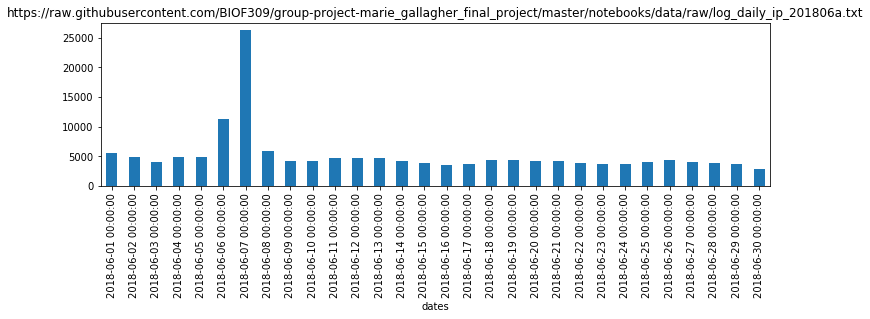

In [22]:
# Display a quick plot.
# The days (not the df index 0, 1, 2...) should display on the x axis
# The unique_ips will be used on the y axis.
# figsize changes the size to 12 (x) by 3 (y).
# title adds the title to the plot.
df.plot.bar(x='dates',figsize=(12,3),title=daily_ip_file,legend=False);

In [23]:
# What was the median number (half above, half below) of unique IP addresses accessed in a day?
print(df.unique_ips.median())

4256.0


In [24]:
# What was the lowest number of unique IP addresses in a day?
print(df.unique_ips.min())

2904


In [25]:
# What day is associated with the lowest number of unique IP addresses?
# The day(s) when df.unique_ips.min() == df.unique_ips
print(df.dates[df.unique_ips==df.unique_ips.min()])

29   2018-06-30
Name: dates, dtype: datetime64[ns]


In [26]:
# What was the highest number of unique IP addresses in a day?
print(df.unique_ips.max())

26206


In [27]:
# What day is associated with the highest number of IP addresses?
# The day(s) when df.unique_ips.max() == df.unique_ips
print(df.dates[df.unique_ips==df.unique_ips.max()])

6   2018-06-07
Name: dates, dtype: datetime64[ns]


## Future

1. I will incorporate this project into my work immediately.  (Until now, I imported the data into Excel and made a graph.)

2. Break my program into functions and restructure my project files

3. Scrub IP addresses from raw log files and extract data from them

4. List the most accessed URLs on days with high IP address counts

5. List the top referrers on days with high IP address counts

## Acknowledgments and Thanks!

BIOF 309 Instructors
* Martin Skarzynski
* Jinping Liu
* Michael Chambers

BIOF 309 Class
* Helpful questions

NIAID Scientific Programming Seminars through CIT
* Burke Squires